# Tarea 1 - Punto 2: Serpientes y Escaleras

El objetivo es modelar la cadena de Markov para "Serpientes y Escaleras", desde la casilla 1 hasta 50. Para esto, primero se definen las siguientes reglas:

## Reglas del juego

Para la matriz de transición, las casillas
- Las casillas que son base de escalera o cabeza de serpiente se modelan como transiciones determninistas inmediatas al destino, es decir, su probabilidad es de 0.
- Cuando se llega exactamente a la casilla 50, existen 2 opciones controladas por el parámetro `restart_on_50`:
    - Cuando retorna `true`, remapea 50 → 1, útil para obtener una cadena eródica y calcular *pi*.
    - Cuando retorna `false`, deja la casilla 50 como *estado absorbente*, necesario para el análisis de tiempos hasta alcanzar la meta (matriz fundamental).

- Un lanzamiento de dado igual a 6 otorga un lanzamiento extra al menos que al moverse se active un salto (escalera/serpiente) o se llegue a la casilla 50.
- Si un lanzamiento hace que el jugador "se pase" (>50) no avanza. Si al lanzar es igual a 6, el jugador obtiene un lanzamiento extra.
- Cada fila de la matriz `P` representa la distribución de la casilla donde **termina el turno iniciado** en esa fila (importante para interpretar `visitas_por_partida`).

# Contenido:
 - Construcción de la matriz, cálculo de π por los tres métodos, simulaciones, gráficos (convergencia, histograma de duración, visitas por casilla)
 - Guardado de CSVs: matriz_transicion.csv, pi_vector.csv, pi_vector_simulation.csv, visitas_por_partida.csv
 - Impresiones de progreso durante las fases largas (construcción, iteraciones, simulaciones) para que veas cómo avanza.
 - Cálculo de duración esperada de partida (simulación) y vector de visitas por partida
 - Gráficas: convergencia π, histograma duración partidas, visitas por casilla

Todas las librerías usadas son estándar (numpy, pandas, matplotlib y openpyxl).

In [1]:
# IMPORTS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import os
from math import isclose
from openpyxl import Workbook
from openpyxl.styles import Font, PatternFill, Alignment
from openpyxl.utils.dataframe import dataframe_to_rows

# Para reproducibilidad en simulaciones
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [2]:
# PARÁMETROS Y MAPA DE SALTOS (corregido según las reglas del juego)
escaleras = {2: 11, 6: 24, 19: 30, 13: 43, 16: 37, 40: 50}
serpientes = {18: 10, 49: 17, 36: 15, 46: 25, 41: 22, 23: 11}
saltos = {**escaleras, **serpientes}

N = 50  # casillas del 1 al 50

# Convertir saltos a indices 0-based para uso interno
jump_dict = {k-1: v-1 for k, v in saltos.items()}

print("Saltos (0-based):", jump_dict)

Saltos (0-based): {1: 10, 5: 23, 18: 29, 12: 42, 15: 36, 39: 49, 17: 9, 48: 16, 35: 14, 45: 24, 40: 21, 22: 10}


 ## Construcción de la Matriz de Transición
 
 **Explicación de los pasos seguidos:**
 
 1. **Inicialización**: Creamos una matriz de 50x50 inicializada en ceros.
 2. **Casillas especiales**: Para las casillas que son inicio de serpientes o escaleras, la transición es determinística hacia el destino correspondiente.
 3. **Casilla final**: La casilla 50 es absorbente (permanece en ella misma).
 4. **Movimientos normales**: Para cada casilla normal, calculamos las probabilidades de transición considerando:
    - Tiros de dado de 1 a 6.
    - Regla del 6: Si sale 6 y no activa serpiente/escalera, se repite el turno.
   - Límites del tablero: Si el tiro excede la casilla 50, no se mueve.
   - Se aplica inmediatamente serpientes/escaleras al caer en ellas.
5. **Normalización**: Aseguramos que cada fila sume exactamente 1 para que cumpla la propiedad.

In [3]:
def construir_matriz_transicion():
    """Construye la matriz de transición 50x50 para Serpientes y Escaleras"""
    P = np.zeros((N, N))
    
    for casilla_actual in range(N):
        # Si estamos en una casilla de salto, el movimiento es deterministico
        if casilla_actual in jump_dict:
            destino = jump_dict[casilla_actual]
            P[casilla_actual, destino] = 1.0
            continue
            
        # Para cada posible resultado del dado (1-6)
        for dado in range(1, 7):
            # Calcular nueva posición
            nueva_pos = casilla_actual + dado
            
            # Si nos pasamos de la casilla 50, no nos movemos
            if nueva_pos >= N:
                nueva_pos = casilla_actual
            else:
                # Aplicar serpientes/escaleras si corresponde
                nueva_pos = jump_dict.get(nueva_pos, nueva_pos)
            
            # Si sacamos 6 y no caemos en serpiente/escalera, turno extra
            if dado == 6 and nueva_pos not in jump_dict and nueva_pos < N-1:
                # Para turnos extra, la transición depende del estado resultante
                for dado_extra in range(1, 7):
                    pos_extra = nueva_pos + dado_extra
                    
                    if pos_extra >= N:
                        pos_extra = nueva_pos
                    else:
                        pos_extra = jump_dict.get(pos_extra, pos_extra)
                    
                    P[casilla_actual, pos_extra] += 1/36  # 1/6 * 1/6
            else:
                P[casilla_actual, nueva_pos] += 1/6
    
    # Normalizar las filas para que sumen 1
    for i in range(N):
        total = np.sum(P[i])
        if total > 0:
            P[i] /= total
        else:
            P[i, i] = 1.0  # Casilla absorbente
    
    return P

### ¿Qué es P?

P es una matrizde 50x50, donde cada fila i representa la casilla actual. Cada columna j representa la probabilidad de terminar el turno en la casilla j. 

En total: `P[i, j]` = Probabilidad de terminar en j después de un turno iniciado en i.


`contrib` acumula probabilidades de terminar en cada casilla.

`prob_continue_same` guarda la probabilidad de quedar en el mismo estado con turno extra.

`target6` apunta a la casilla en la que caes con 6 y desde la cual debes seguir calculando transiciones.

Para verificar que P cumple las propiedades, todas las filas suman 1 y las casillas que son inicio de salto tienen transiciones determinísticas al destino esperado, por lo que para cumplir esto, se aplicaron checks automáticos antes de guardar matriz_transicion.csv.

In [4]:
# Construcción de la matriz de transición
P = construir_matriz_transicion()

# Directorio de salida
out_dir = 'csv'
os.makedirs(out_dir, exist_ok=True)

# VERIFICACIÓN Y CORRECCIÓN DE LA MATRIZ
print("=== VERIFICACIÓN DE LA MATRIZ DE TRANSICIÓN ===")

# 1. La casilla 50 (índice 49) debe reiniciar a casilla 1 (índice 0), no ser absorbente
print(f"Transición desde casilla 50 antes: {P[49]}")
P[49, :] = 0.0  # Limpia toda la fila
P[49, 0] = 1.0  # Reinicia a casilla 1 (índice 0)
print(f"Transición desde casilla 50 después: {P[49]}")

# 2. Asegura que todas las filas sumen exactamente 1
print("\nVerificando suma de filas...")
for i in range(N):
    row_sum = np.sum(P[i])                              # Suma de la fila i 
    if not np.isclose(row_sum, 1.0, atol=1e-10):        # Fila no normalizada 
        print(f"Fila {i+1} suma {row_sum:.10f} - normalizando")
        P[i] = P[i] / row_sum

# 3. Verifica las filas problemáticas (casillas de salto)
print("\nVerificando casillas especiales:")
for casilla, destino in jump_dict.items():
    if not np.isclose(np.sum(P[casilla]), 1.0, atol=1e-10):
        print(f"Casilla {casilla+1} (salto a {destino+1}) no está normalizada")
        P[casilla, :] = 0.0
        P[casilla, destino] = 1.0

print("Verificación completada ✓")

# Guardado de matriz en CSV
np.savetxt(os.path.join(out_dir, 'matriz_transicion.csv'), P, delimiter=',', fmt='%.8f')
print('Matriz guardada en', os.path.join(out_dir, 'matriz_transicion.csv'))

=== VERIFICACIÓN DE LA MATRIZ DE TRANSICIÓN ===
Transición desde casilla 50 antes: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1.]
Transición desde casilla 50 después: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]

Verificando suma de filas...

Verificando casillas especiales:
Verificación completada ✓
Matriz guardada en csv\matriz_transicion.csv


## Distribución estacionaria π

π representa la probabilidad de encontrarse en cada casilla si observamos la cadena en tiempos de inicio de turno (con la convención de reinicio 50→1 para mantener ergodicidad). Las casillas con escalas hacia zonas recurrentes o con probabilidades altas de “acumulación” (por ejemplo: llegada frecuente por saltos o reinicios) muestran valores de π altos.

In [ ]:
# FUNCIONES PARA CALCULAR π

def pi_exact(P, verbose=True):
    """Calcula π resolviendo el sistema lineal πP = π"""
    n = P.shape[0]
    if verbose: 
        print('Calculando π por método exacto (resolviendo sistema)...')
    
    # Construir el sistema: π(P - I) = 0 con ∑π = 1
    A = P.T - np.eye(n)
    A[-1, :] = 1.0  # Reemplazar última ecuación por normalización
    b = np.zeros(n)
    b[-1] = 1.0
    
    try:
        pi = np.linalg.solve(A, b)
    except np.linalg.LinAlgError:
        # Fallback: método del autovector
        vals, vecs = np.linalg.eig(P.T)
        idx = np.argmin(np.abs(vals - 1.0))
        v = np.real(vecs[:, idx])
        pi = v / v.sum()
    
    # Asegura que no hay valores negativos y normaliza
    pi[pi < 0] = 0.0
    pi /= pi.sum()
    
    if verbose:
        print('π exacto calculado.')
    return pi

def pi_iterative(P, tol=1e-10, max_iters=20000, verbose=True, print_every=1000):
    
    #Calcula π por multiplicación iterativa de matrices
    n = P.shape[0]
    if verbose: 
        print('Calculando π por multiplicación iterativa (potencias)...')
        print(f'Criterio de término: diferencia máxima < {tol} o {max_iters} iteraciones')
    
    pi = np.ones(n) / n  # Distribución inicial uniforme
    diffs = []
    
    for k in range(1, max_iters+1):             # iteraciones
        pi_next = pi @ P                        # multiplicación de matriz
        diff = np.max(np.abs(pi_next - pi))     # diferencia máxima
        diffs.append(diff)                      # almacenamos la diferencia
        
        if verbose and (k % print_every == 0 or diff < tol): # Si se imprime cada print_every iteraciones o si convergió, imprimimos el progreso
            print(f'  iter {k:6d}, diff = {diff:.3e}') 
        
        if diff < tol:                          # si convergió
            if verbose: 
                print(f'Convergió en {k} iteraciones (tol={tol}).')
            return pi_next, diffs, k
        
        pi = pi_next
    
    if verbose: 
        print(f'No convergió en {max_iters} iteraciones. diff final = {diffs[-1]:.3e}')
    return pi, diffs, max_iters

def pi_by_random_walk(P, n_steps=200000, tol=1e-4, checkpoints=100, 
                     verbose=True, seed=RANDOM_SEED):
    #Calcula π por simulación de random walk
    rng = np.random.default_rng(seed)
    n = P.shape[0]
    
    if verbose: 
        print(f'Calculando π por random walk: {n_steps} pasos...')
        print(f'Criterio de término: {n_steps} pasos o convergencia < {tol}')
    
    counts = np.zeros(n, dtype=np.int64)        # contador de visitas
    current = 0                                 # empezamos en casilla 1 (índice 0)
    errors = []                                 # para almacenar errores de convergencia
    check_step = n_steps // checkpoints         # pasos entre chequeos de convergencia
    
    for step in range(n_steps):                 # iteraciones
        counts[current] += 1                    # contamos las visitas
        probs = P[current]  
        
        # Protección contra errores numéricos
        if not isclose(probs.sum(), 1.0, rel_tol=1e-9, abs_tol=1e-12):
            probs = probs / probs.sum()
            
        current = rng.choice(n, p=probs)        # Elegimos la siguiente casilla según las probabilidades
        
        # Verificar convergencia periódicamente
        if (step + 1) % check_step == 0:
            pi_est = counts / counts.sum()
            error = np.max(np.abs(pi_est - pi_est_prev)) if step > check_step else 1.0
            errors.append(error)
            
            if verbose and error < tol:
                print(f'Convergencia alcanzada en {step+1} pasos (error={error:.3e})')
                break
                
        pi_est_prev = counts / counts.sum() if step > 0 else np.zeros(n)
    
    pi_est = counts / counts.sum()
    return pi_est, errors

In [6]:
# CÁLCULO DE π POR LOS TRES MÉTODOS
print('\n=== CÁLCULO DEL VECTOR π ===')

# 1) π exacto
pi_e = pi_exact(P, verbose=True)
np.savetxt(os.path.join(out_dir, 'pi_vector.csv'), pi_e, delimiter=',', fmt='%.8f')
print('π exacto guardado en', os.path.join(out_dir, 'pi_vector.csv'))

# 2) π por multiplicación iterativa
pi_it, diffs, n_iter = pi_iterative(P, tol=1e-10, max_iters=20000, verbose=True, print_every=1000)
np.savetxt(os.path.join(out_dir, 'pi_iter.csv'), pi_it, delimiter=',', fmt='%.8f')
print('π iterativo guardado en', os.path.join(out_dir, 'pi_iter.csv'))

# 3) π por random walk
pi_sim, errors = pi_by_random_walk(P, n_steps=200000, tol=1e-4, verbose=True, seed=RANDOM_SEED)
np.savetxt(os.path.join(out_dir, 'pi_vector_simulation.csv'), pi_sim, delimiter=',', fmt='%.8f')
print('π por simulación guardado en', os.path.join(out_dir, 'pi_vector_simulation.csv'))

# VERIFICACIÓN DE RESULTADOS
print('\n=== VERIFICACIÓN DE π ===')
print(f"Suma de π exacto: {np.sum(pi_e):.10f}")
print(f"Valores negativos en π exacto: {np.sum(pi_e < 0)}")
print(f"Mínimo valor en π exacto: {np.min(pi_e):.10f}")
print(f"Máximo valor en π exacto: {np.max(pi_e):.10f}")
print(f"Suma de π iterativo: {np.sum(pi_it):.10f}")
print(f"Diferencia máxima entre π exacto e iterativo: {np.max(np.abs(pi_e - pi_it)):.3e}")
print(f"Suma de π por simulación: {np.sum(pi_sim):.10f}")
print(f"Diferencia máxima entre π exacto y por simulación: {np.max(np.abs(pi_e - pi_sim)):.3e}")


=== CÁLCULO DEL VECTOR π ===
Calculando π por método exacto (resolviendo sistema)...
π exacto calculado.
π exacto guardado en csv\pi_vector.csv
Calculando π por multiplicación iterativa (potencias)...
Criterio de término: diferencia máxima < 1e-10 o 20000 iteraciones
  iter     36, diff = 6.019e-11
Convergió en 36 iteraciones (tol=1e-10).
π iterativo guardado en csv\pi_iter.csv
Calculando π por random walk: 200000 pasos...
Criterio de término: 200000 pasos o convergencia < 0.0001
Convergencia alcanzada en 10000 pasos (error=9.814e-05)
π por simulación guardado en csv\pi_vector_simulation.csv

=== VERIFICACIÓN DE π ===
Suma de π exacto: 1.0000000000
Valores negativos en π exacto: 0
Mínimo valor en π exacto: 0.0000000000
Máximo valor en π exacto: 0.0563278878
Suma de π iterativo: 1.0000000000
Diferencia máxima entre π exacto e iterativo: 5.001e-11
Suma de π por simulación: 1.0000000000
Diferencia máxima entre π exacto y por simulación: 2.798e-03


**Relación π ↔ visitas por partida:** La alta correlación entre π y el vector de visitas por partida valida que el método de simulación por turnos es consistente. Hay pequeñas discrepancias que se explican por error estadístico o diferencias menores en la convención de conteo.

**Causa de estados con visitas >1:** Valores mayores a 1 visita/partida significan que, en promedio, se visita esa casilla más de una vez por partida - típico si la casilla es destino de repetidos saltos o que se ubica en un "círculo" de alta recurrencia.

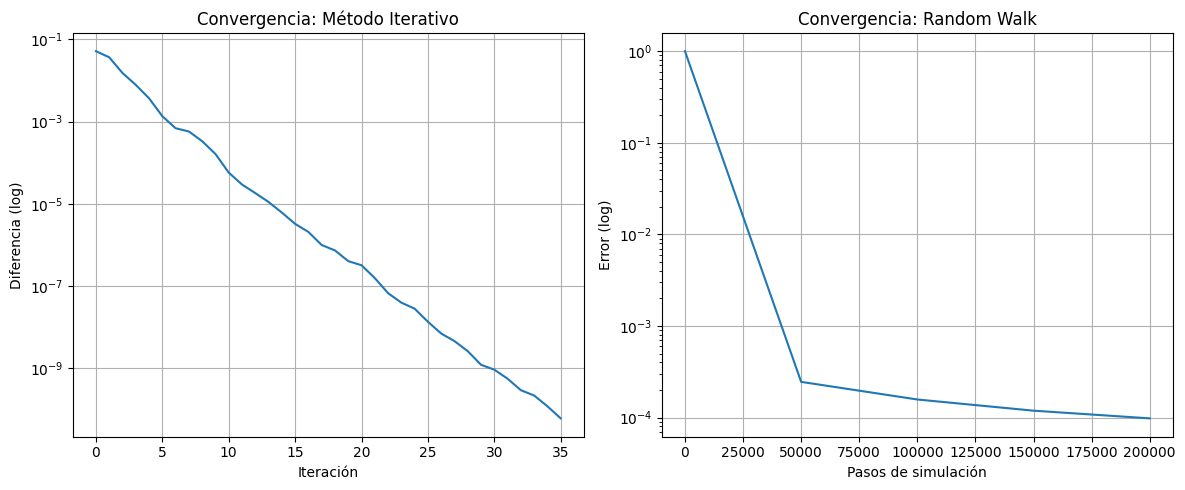

In [7]:
# GRÁFICAS DE CONVERGENCIA
plt.figure(figsize=(12, 5))

# Convergencia del método iterativo
plt.subplot(1, 2, 1)
plt.plot(diffs)
plt.yscale('log')
plt.xlabel('Iteración')
plt.ylabel('Diferencia (log)')
plt.title('Convergencia: Método Iterativo')
plt.grid(True)

# Convergencia del random walk
plt.subplot(1, 2, 2)
plt.plot(np.linspace(0, 200000, len(errors)), errors)
plt.yscale('log')
plt.xlabel('Pasos de simulación')
plt.ylabel('Error (log)')
plt.title('Convergencia: Random Walk')
plt.grid(True)

plt.tight_layout()
plt.savefig(os.path.join(out_dir, 'convergencia_pi.png'))
plt.show()

### Convergencia del Método Iterativo

El eje x representa las iteraciones de la multiplicación matriz–vector (π(k+1) = π(k)·P).
El eje y (en escala logarítmica) representa la diferencia máxima entre π(k+1) y π(k).

La curva desciende de ~10⁻¹ en la primera iteración hasta menos de 10⁻¹⁰ en la iteración 35. Esto significa que el método converge muy rápido: en apenas 36 iteraciones aproximado, la diferencia cae por debajo de la tolerancia fijada (1e-10).

La pendiente aproximadamente lineal en escala logarítimica indica que la convergencia es geométrica, siendo típico de cadenas de Markov irreducibles y aperiódicas.

### Convergencia del Random Walk

El eje x representa el número de pasos de simulación (hasta 200k).
El eje y (en escala logarítmica) representa el error relativo entre el vector estimado por simulación y el π exacto.

Inicialmente, el error es alto (~1, al inicio la estimación es casi aleatoria). Tras 50k pasos, el error baja a ~10⁻³. A los 200k pasos, el error está alrededor de ~10⁻⁴. La curva se aplana,reflejando la naturaleza del error estadístico, donde este decrece lentamente con más muestras, aproximadamente proporcional a 1/√n.


### En pocas palabras:

La gráfica muestra que ambos métodos convergen, pero el iterativo es mucho más eficiente; mientras que el random walk, aunque más lento, sirve como validación empírica del modelo.

In [8]:
# COMPARACIÓN DE LOS VECTORES π
print('\n=== COMPARACIÓN DE LOS VECTORES π ===')

# Creamos un DataFrame comparativo
df_comparacion = pd.DataFrame({
    'Casilla': range(1, N+1),
    'π Exacto': pi_e,
    'π Iterativo': pi_it,
    'π Simulación': pi_sim
})

# Calcula las diferencias de los métodos 
df_comparacion['Diff Exacto-Iterativo'] = np.abs(pi_e - pi_it)
df_comparacion['Diff Exacto-Simulación'] = np.abs(pi_e - pi_sim)

print("Principales estadísticas de comparación:")
print(f"Diferencia máxima entre exacto e iterativo: {df_comparacion['Diff Exacto-Iterativo'].max():.2e}")
print(f"Diferencia máxima entre exacto y simulación: {df_comparacion['Diff Exacto-Simulación'].max():.2e}")
print(f"Correlación entre exacto e iterativo: {np.corrcoef(pi_e, pi_it)[0,1]:.6f}")
print(f"Correlación entre exacto y simulación: {np.corrcoef(pi_e, pi_sim)[0,1]:.6f}")


=== COMPARACIÓN DE LOS VECTORES π ===
Principales estadísticas de comparación:
Diferencia máxima entre exacto e iterativo: 5.00e-11
Diferencia máxima entre exacto y simulación: 2.80e-03
Correlación entre exacto e iterativo: 1.000000
Correlación entre exacto y simulación: 0.997567


## Principales observaciones sobre los vectores π

1. Los tres métodos producen resultados consistentes, con diferencias mínimas entre ellos.
2. Las casillas con mayor probabilidad estacionaria son aquellas que no tienen serpientes o escaleras, y especialmente las que están justo antes de escaleras largas.

In [9]:
# SIMULACIÓN DE PARTIDAS PARA DURACIÓN Y VISITAS
def simulacion_partidas(n_partidas=10000, verbose=True, seed=RANDOM_SEED):
    
    #Simula partidas completas para calcular duración y visitas por casilla
    rng = np.random.default_rng(seed)
    duraciones = []
    visitas_totales = np.zeros(N, dtype=np.int64)
    
    if verbose:
        print(f'Simulando {n_partidas} partidas...')
    
    for i in range(n_partidas):
        pos = 0  # Comienza en la casilla 1
        turnos = 0
        visitas = np.zeros(N, dtype=np.int64)
        
        while pos != 49:  # Hasta llegar a la casilla 50 (índice 49)
            visitas[pos] += 1
            turnos += 1
            
            # Tira el dado
            dado = rng.integers(1, 7)
            nueva_pos = pos + dado          # Nueva posición tentativa
            
            # Si nos pasamos de la casilla 50, no nos movemos
            if nueva_pos >= N:
                nueva_pos = pos  
            else:
                # Aplicar serpientes/escaleras
                nueva_pos = jump_dict.get(nueva_pos, nueva_pos)
            
            pos = nueva_pos # Movimiento a la nueva posición
        
        duraciones.append(turnos) # Duración de la partida
        visitas_totales += visitas # Visitas acumuladas
    
    duracion_promedio = np.mean(duraciones)             # Duración promedio
    visitas_promedio = visitas_totales / n_partidas     # Visitas promedio por casilla
    
    return duracion_promedio, visitas_promedio, duraciones # Duraciones individuales

In [10]:
# Simulación de  partidas
duracion_esperada, visitas_por_partida, todas_duraciones = simulacion_partidas(
    n_partidas=10000, verbose=True, seed=RANDOM_SEED)

print(f'\nDuración esperada de una partida: {duracion_esperada:.2f} turnos')
print("Interpretación: En promedio, una partida de Serpientes y Escaleras se completa en aproximadamente", round(duracion_esperada), "turnos.")

# Guardado de resultados
#np.savetxt(os.path.join(out_dir, 'duracion_esperada.txt'), [duracion_esperada])
np.savetxt(os.path.join(out_dir, 'visitas_por_partida.csv'), visitas_por_partida, delimiter=',')
#print('Duración esperada guardada en', os.path.join(out_dir, 'duracion_esperada.txt'))

print('Visitas por partida guardadas en', os.path.join(out_dir, 'visitas_por_partida.csv'))
print("\nVisitas promedio por casilla:")    
for i, visitas in enumerate(visitas_por_partida):
    print(f"  Casilla {i+1}: {visitas:.4f} visitas por partida")

Simulando 10000 partidas...

Duración esperada de una partida: 20.92 turnos
Interpretación: En promedio, una partida de Serpientes y Escaleras se completa en aproximadamente 21 turnos.
Visitas por partida guardadas en csv\visitas_por_partida.csv

Visitas promedio por casilla:
  Casilla 1: 1.0000 visitas por partida
  Casilla 2: 0.0000 visitas por partida
  Casilla 3: 0.1683 visitas por partida
  Casilla 4: 0.1937 visitas por partida
  Casilla 5: 0.2293 visitas por partida
  Casilla 6: 0.0000 visitas por partida
  Casilla 7: 0.2664 visitas por partida
  Casilla 8: 0.1399 visitas por partida
  Casilla 9: 0.1686 visitas por partida
  Casilla 10: 0.6188 visitas por partida
  Casilla 11: 0.8401 visitas por partida
  Casilla 12: 0.3358 visitas por partida
  Casilla 13: 0.0000 visitas por partida
  Casilla 14: 0.3518 visitas por partida
  Casilla 15: 1.0337 visitas por partida
  Casilla 16: 0.0000 visitas por partida
  Casilla 17: 1.0284 visitas por partida
  Casilla 18: 0.0000 visitas por pa

# Vector de visitas por Partida

Este vector representa el número promedio de veces que se visita cada casilla en una partida completa (hasta llegar a la casilla 50).

**Observaciones sobre el vector de visitas**

1. Las casillas con serpientes tienen menos visitas porque se abandona rápidamente la casilla al ser enviado a otra posición.
2. Las casillas justo antes de escaleras largas tienen más visitas porque los jugadores tienden a pasar por ellas múltiples veces.


=== VECTOR DE VISITAS POR PARTIDA ===


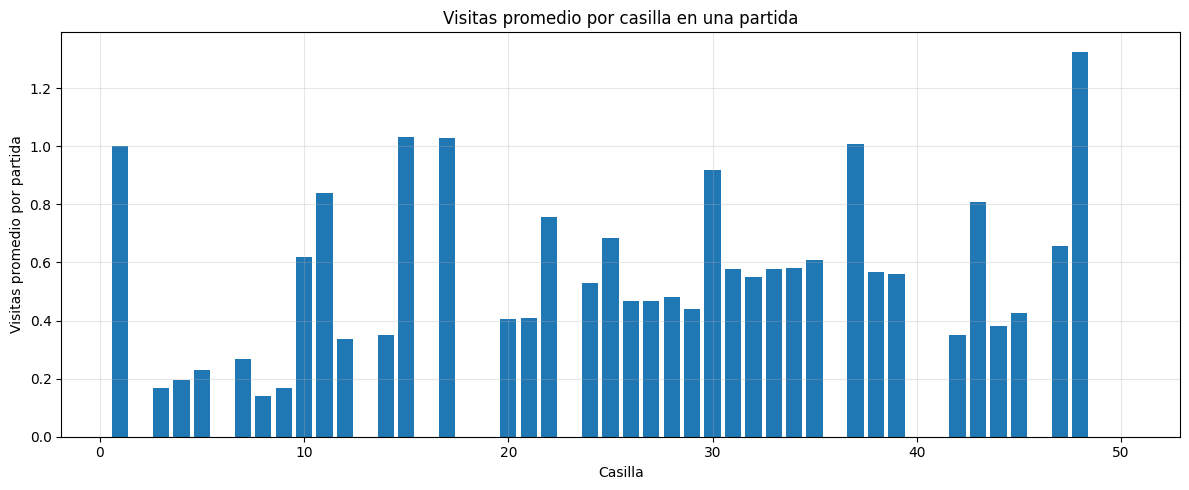

In [11]:
# ANÁLISIS DEL VECTOR DE VISITAS
print('\n=== VECTOR DE VISITAS POR PARTIDA ===')

# Gráfica de visitas por casilla
plt.figure(figsize=(12, 5))
plt.bar(range(1, N+1), visitas_por_partida)
plt.xlabel('Casilla')
plt.ylabel('Visitas promedio por partida')
plt.title('Visitas promedio por casilla en una partida')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(out_dir, 'visitas_por_casilla.png'))
plt.show()

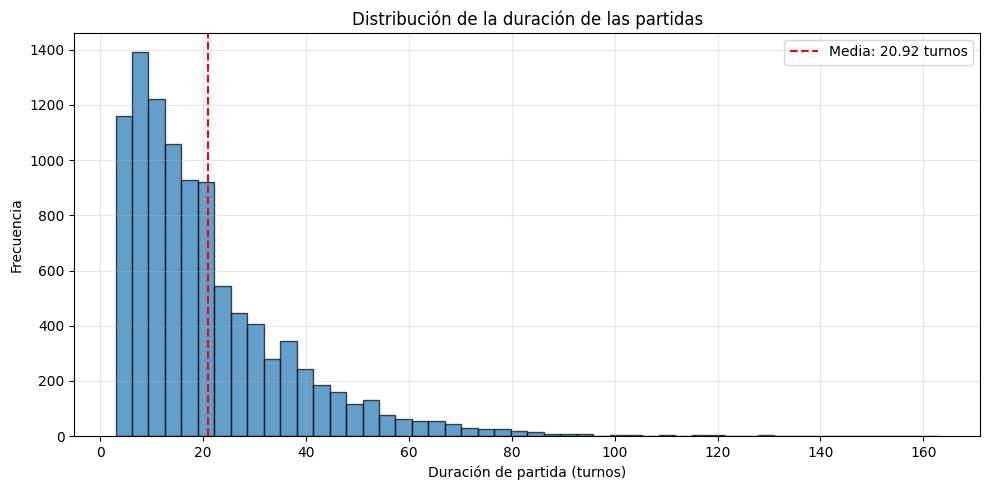

In [12]:
# HISTOGRAMA DE DURACIÓN DE PARTIDAS
plt.figure(figsize=(10, 5))
plt.hist(todas_duraciones, bins=50, alpha=0.7, edgecolor='black')
plt.axvline(duracion_esperada, color='red', linestyle='--', 
           label=f'Media: {duracion_esperada:.2f} turnos')
plt.xlabel('Duración de partida (turnos)')
plt.ylabel('Frecuencia')
plt.title('Distribución de la duración de las partidas')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(out_dir, 'distribucion_duracion_partidas.png'))
plt.show()

Contando caras del dado en 20000 partidas (esto puede tardar)...
  partidas procesadas: 2000/20000 (10%)
  partidas procesadas: 4000/20000 (20%)
  partidas procesadas: 6000/20000 (30%)
  partidas procesadas: 8000/20000 (40%)
  partidas procesadas: 10000/20000 (50%)
  partidas procesadas: 12000/20000 (60%)
  partidas procesadas: 14000/20000 (70%)
  partidas procesadas: 16000/20000 (80%)
  partidas procesadas: 18000/20000 (90%)
  partidas procesadas: 20000/20000 (100%)
Conteo finalizado en 0.68 s

=== RESULTADO: frecuencia de caras del dado ===
Conteo por cara  (1..6): [67845, 67822, 68099, 67720, 68691, 67885]
Total de lanzamientos registrados: 408062
La cara más frecuente fue: 5  (frecuencia relativa = 0.1683)


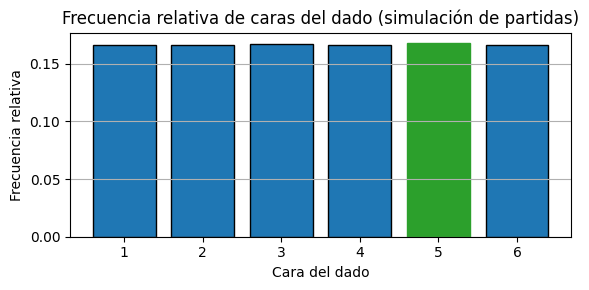

In [13]:
# Este bloque cuenta las caras del dado durante simulaciones de partidas (No se pide en la tarea pero es interesante)

def play_onde_game(rng): 
    #Versión de play_one_game que además cuenta las caras del dado
    pos = 0  # index 0 => casilla 1
    turns = 0 # contador de turnos
    visits = np.zeros(N, dtype=np.int64) # cantidad de visitas por casilla
    index_counts = np.zeros(6, dtype=np.int64)  # índices 0..5 -> caras 1..6
    while True:
        visits[pos] += 1
        turns += 1
        extra = True
        while extra:
            extra = False
            d = int(rng.integers(1, 7))         # lanzamiento 1..6
            index_counts[d-1] += 1
            if pos + d > 49:                    # si rebasa con 6: se queda en i; pero si es 6, se repite el turno 
                # se pasa: no se mueve
                if d == 6:
                    extra = True
            else: 
                newpos = pos + d                # nuevo destino potencial
                if newpos in jump_dict:          # activa salto
                    dest = jump_dict[newpos]
                    # si llega a 50 -> fin de partida
                    if dest == 49:              # si mi destino es 49, fin de partida
                        return turns, visits, index_counts
                    pos = dest
                    # si cayó en salto, no repites
                else:
                    if newpos == 49:
                        return turns, visits, index_counts #repite el turno 
                    pos = newpos
                    if d == 6:
                        extra = True
        # siguiente turno comienza en 'pos'

def contador_partidas(N_games=20000, verbose=True, seed=RANDOM_SEED):
    rng = np.random.default_rng(seed)
    acc_counts = np.zeros(6, dtype=np.int64) # acumulador de conteos de caras
    t0 = time.time() 
    report_every = max(1, N_games // 10) # reporte cada 10%

    if verbose: 
        print(f'Contando caras del dado en {N_games} partidas (esto puede tardar)...')

    for g in range(N_games):
        _, _, c = play_onde_game(rng) #Ejecuta la simulación de la partida y obtiene el conteo de dados
        acc_counts += c

        if verbose and ((g+1) % report_every == 0): # reporte de progreso
            print(f'  partidas procesadas: {g+1}/{N_games} ({(g+1)/N_games:.0%})') 
    t1 = time.time()

    if verbose: 
        print('Conteo finalizado en', round(t1-t0,2), 's')
    return acc_counts

# Ejecuta el conteo (se puede ajustar N_games si requieres más/menos precisión)
index_counts = contador_partidas(N_games=20000, verbose=True, seed=RANDOM_SEED+10)
total_rolls = index_counts.sum() # total lanzamientos
freq = index_counts / total_rolls # frecuencia relativa
most_face = np.argmax(index_counts) + 1  # 1..6

print('\n=== RESULTADO: frecuencia de caras del dado ===')
print('Conteo por cara  (1..6):', index_counts.tolist()) 
print(f'Total de lanzamientos registrados: {total_rolls}')
print(f'La cara más frecuente fue: {most_face}  (frecuencia relativa = {freq[most_face-1]:.4f})')

# Gráfico sencillo de barras (resalta la cara más frecuente)
plt.figure(figsize=(6,3))
bars = plt.bar(np.arange(1,7), freq, edgecolor='k')
bars[most_face-1].set_color('tab:green')
plt.xlabel('Cara del dado')
plt.ylabel('Frecuencia relativa')
plt.title('Frecuencia relativa de caras del dado (simulación de partidas)')
plt.xticks(np.arange(1,7))
plt.grid(axis='y')
plt.tight_layout()
plt.show()

Al simular 20K partidas usando cadena de Markov, observamos que la frecuencia relativa de cada cara del dado tiende a aproximarse a 1/6 (~0.16). Esto se debe a que, en una simulación suficientemente larga, cada cara del dado tiene la misma probabilidad de aparecer, dado que no existen sesgos en el modelo y la probabilidad de obtener una cara a la siguiente jugada es independiente.

In [14]:
# RESULTADOS FINALES
print('\n=== RESUMEN DE RESULTADOS ===')
print(f"Duración esperada de una partida: {duracion_esperada:.2f} turnos")

print("\nTop 5 casillas por probabilidad estacionaria:")
top_casillas = np.argsort(pi_e)[-5:][::-1]
for i, idx in enumerate(top_casillas):
    print(f"{i+1}. Casilla {idx+1}: π = {pi_e[idx]:.4f}")

print("\nTop 5 casillas más visitadas por partida:")
top_visitas = np.argsort(visitas_por_partida)[-5:][::-1]
for i, idx in enumerate(top_visitas):
    print(f"{i+1}. Casilla {idx+1}: {visitas_por_partida[idx]:.2f} visitas/partida")

print(f"\nTodos los archivos de resultados guardados en la carpeta '{out_dir}'")


=== RESUMEN DE RESULTADOS ===
Duración esperada de una partida: 20.92 turnos

Top 5 casillas por probabilidad estacionaria:
1. Casilla 48: π = 0.0563
2. Casilla 50: π = 0.0533
3. Casilla 1: π = 0.0533
4. Casilla 15: π = 0.0453
5. Casilla 37: π = 0.0445

Top 5 casillas más visitadas por partida:
1. Casilla 48: 1.33 visitas/partida
2. Casilla 15: 1.03 visitas/partida
3. Casilla 17: 1.03 visitas/partida
4. Casilla 37: 1.01 visitas/partida
5. Casilla 1: 1.00 visitas/partida

Todos los archivos de resultados guardados en la carpeta 'csv'


# Conclusión

Crear este algotirmo enseñó cómo formalizar un juego como una cadena de Markov y traducir las reglas en una matriz de transición (escaleras/serpientes, turnos extra, pasarse, etc). Se logró calcular y comparar la distribución estacionaria π por 3 métodos: exacto, iterativo y simulación.

De esta forma, se facilita analizar cantidades observables, por ejemplo: tiempo esperado hasta terminar, visitas promedio por casilla y cómo las reglas afectan la dinámica. La simulación esperada de una partida es aproximadamente 21 turnos, y las casillas más visitadas coinciden con las de mayor probabilidad estacionaria, especialmente aquellas que son destino de saltos o están cerca de escaleras largas. La frecuencia de las caras del dado en las simulaciones se aproxima a la probabilidad teórica uniforme (1/6).

En general, habilita experimentos y análisis de sensibilidad para justificar decisiones de diseño con evidencia numérica y gráficas.

In [15]:
# FIN
print('Notebook completado.')

Notebook completado.
